In [ ]:
#Part by ETHEVE Braz-ma
import networkx as nx
import pandas as pd

df = pd.read_csv('data/2015-1-1.csv')
df.head()

,Source,Target,value,nb_transactions
0,1155021,Xapo.com,6500,1
1,CoinKite.com,Coins-e.com,13000,1
2,69146577,ePay.info_CoinJoinMess,14977,1
3,CoinKite.com,Poloniex.com,15222,1
4,72602063,265,27360,1


We choose a multi-directed graph because there may be multiple transactions for a Source/Target pair in a day, resulting in parallel directed edges.

In [ ]:
Graphtype = nx.MultiDiGraph() 
G = nx.from_pandas_edgelist(df,source = "Source",target = "Target", edge_attr=True, create_using= Graphtype)

In [ ]:
print(G['72602063']['265'])

{0: {'value': 27360, 'nb_transactions': 1}}


First of all, we import the data and verify the graph is as intended :


The nodes are Source -> Target ✅

The edges carry two values : the value of the transaction and the number of transactions ✅

# Visualizing a graph


Code inspired from networkx tutorial : https://networkx.org/documentation/stable/auto_examples/drawing/plot_directed.html#sphx-glr-auto-examples-drawing-plot-directed-py

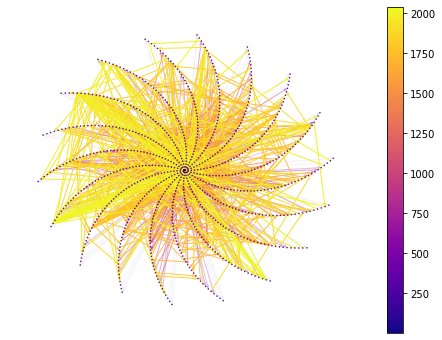

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

pos = nx.spiral_layout(G)

node_sizes = [0.3 for i in range(len(G))]

M = G.number_of_edges()
edge_colors = range(2, M + 2)
edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
cmap = plt.cm.plasma

# larger figure size
plt.figure(1,figsize=(8,6)) 
nodes = nx.draw_networkx_nodes(G, pos,node_size=node_sizes, node_color="indigo")
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=5,
    edge_color=edge_colors,
    edge_cmap=cmap,
    width=1,
)
# set alpha value for each edge
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=cmap)
pc.set_array(edge_colors)

ax = plt.gca()
ax.set_axis_off()

plt.colorbar(pc, ax=ax)
plt.show()

As we can see, the graph is too complex to compare visually multiple graphs or even read it in a single matplotlib plot. As such, we need some data analysis tools to understand it better.

# Anomaly Detection in graphs

Anomaly detection is an NP-hard problem, so there is no easy single way of detecting anomalies in a graph. However there are multiple approaches that attempt to solve this very difficult task in linear time.

First of all, an anomaly is what deviates from the norm. As such, to detect an anomaly, we must first establish what is a "normal" graph. To achieve that, we will attempt to characterize each graph with a vector of values, in what's called Graph Embedding.

There are multiple ways (non-exhaustive) to do graph embedding : 

*   Matrix Factorization
*   Random Walk (we will use this with node2vec)
*   Deep Learning approaches

First we analyze the data to see if we can simplify it for the ML algorithms.

Then our approach is to use Isolation Forests from sklearn to detect the outliers, it is a random forest algorithm designed to detect anomalies in datasets. Here we first need the embedding to get a dataset of datasets (graphs)

# Data Analysis

Since complete analysis of graphs is very time and resource consuming, we will focus on these following points : 

*   Sort the transactions from highest to lowest value and filter
*   Analyze the nb_transactions dimension to evaluate the % of non-singular transactions
*   Try out Random Walk graph embedding





In [ ]:
len(df)

2041

In [ ]:
df_filtered = df[df['nb_transactions'] == 1]
percentage = len(df_filtered)/len(df)
print('nb of singular transactions :',len(df_filtered))
print(percentage)

nb of singular transactions : 1283
0.6286134247917687


As we can see, there are too many non-singular transactions to remove the column, it brings value to the data so we will therefore keep it.

In [ ]:
df_sorted = df.sort_values(by='value',ascending=False)
df_sorted.head(10)

,Source,Target,value,nb_transactions
2040,ePay.info_CoinJoinMess,OKCoin.com,54729885407855,682
2039,ePay.info_CoinJoinMess,Huobi.com,45243002887819,563
2038,ePay.info_CoinJoinMess,424,23492138110938,296
2037,ePay.info_CoinJoinMess,BTCCPool,20331309738060,256
2036,ePay.info_CoinJoinMess,525,14947066673418,186
2035,ePay.info_CoinJoinMess,Bter.com,10692291122731,134
2034,ePay.info_CoinJoinMess,BtcTrade.com,9803993358080,123
2033,ePay.info_CoinJoinMess,Btc38.com,7312852121612,92
2032,ePay.info_CoinJoinMess,1647,7071730469144,88
2031,ePay.info_CoinJoinMess,0,4304622667568,275


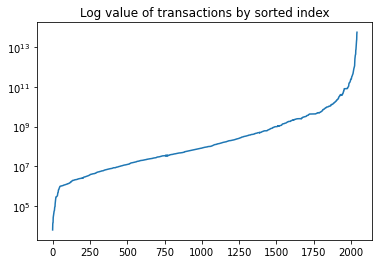

In [ ]:
import matplotlib.pyplot as plt
plt.yscale('log')
plt.title('Log value of transactions by sorted index')
df_sorted['value'].plot()

As we can see in this dataset, there are a few very high value transactions (top 250 transactions) but most follow a linear function in the log plane (if we ignore the start), so they follow an exponential function. In other words, there is maybe a pattern when we compare the values of different graphs.

Before moving on, we'll try to divide the value by the nb_transactions, assuming they are all of equal value (which they are not in reality, so it's an approximation)

In [ ]:
df_sorted_norm = df_sorted['value']/df_sorted['nb_transactions']
df_sorted_norm.head()

2040    8.024910e+10
2039    8.036057e+10
2038    7.936533e+10
2037    7.941918e+10
2036    8.036057e+10
dtype: float64

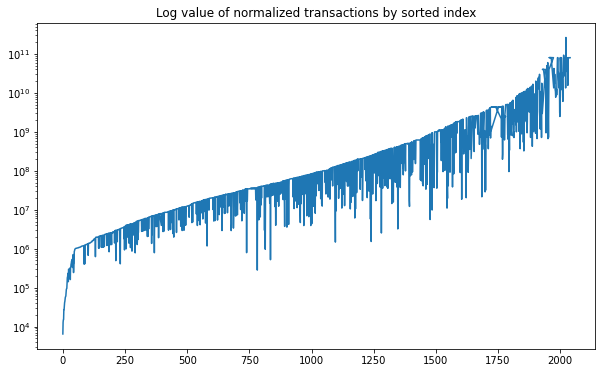

In [ ]:
plt.yscale('log')
plt.title('Log value of normalized transactions by sorted index')
df_sorted_norm.plot(figsize=(10,6))

As we can see, the value curve is now much smoother in the log plane, but normalizing it by the number of transactions created some distortions in the dataset. As such, we'll keep the previous version as it would be less prone to misclassification.

# Using Node2Vec for graph embedding

code inspired from a Node2Vec tutorial : https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/embeddings/node2vec-embeddings.ipynb#scrollTo=xNpGgRGInrcZ

In [ ]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.2/435.2 KB 24.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.3/500.3 KB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.6 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd
from stellargraph import datasets
from IPython.display import display, HTML


In [ ]:
from stellargraph.data import BiasedRandomWalk
import stellargraph as sg

G = sg.StellarDiGraph(edges= df,source_column = "Source",target_column = "Target")
print(G.info())

StellarDiGraph: Directed multigraph
 Nodes: 852, Edges: 2041

 Node types:
  default: [852]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [2041]
        Weights: all 1 (default)
        Features: float32 vector, length 2


the line `Features: float32 vector, length 2` indicates that value and number of transactions are counted as features of the edge.

In [ ]:
rw = BiasedRandomWalk(G)

walks = rw.run(
    nodes=list(G.nodes()),  # root nodes
    length=100,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
)
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 8520


We then use the Word2Vec model from gensim to convert the random walk "sentences" into vectors of size 128

In [ ]:
from gensim.models import Word2Vec

str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(str_walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)

In [ ]:
# The embedding vectors can be retrieved from model.wv using the node ID.
model.wv["1155021"].shape

(128,)

# Plot the 2D projection

We retrieve the Word2Vec node embeddings that are 128-dimensional vectors and then we project them down to 2 dimensions using the t-SNE algorithm.

node_embeddings is a 852*128 vector

In [ ]:
# Retrieve node embeddings
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality

In [ ]:
transform = TSNE 

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


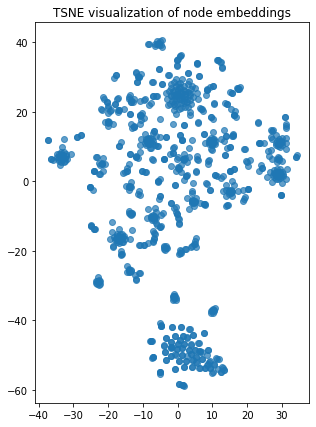

In [ ]:
# draw the embedding points
alpha = 0.7

plt.figure(figsize=(7, 7))
plt.axes().set(aspect="equal")
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    cmap="jet",
    alpha=alpha,
)
plt.title("{} visualization of node embeddings".format(transform.__name__))
plt.show()

For this example, we can see that different clusters arise from this embedding. However we are not here to cluster the contents of each graph but to determine whether it is abnormal compared to the rest of the graphs.

We succeeded in step 1 : transforming a graph into a set of numerical vectors that can be compared with eachother.

We then need to apply all these steps on all the graphs datasets and build a dataset of graph embeddings.

Then we need to numerically compare each graph relative to each other (computationally very costly) using a comparison metric.

# Iterating over multiple graphs